In [ ]:
# import packages
import numpy as np
import cvxopt as cvx
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
# import data
data_set_X = np.genfromtxt("hw06_data_set_images.csv", delimiter = ",")
data_set_y = np.genfromtxt("hw06_data_set_labels.csv", delimiter = ",")

split_location = 1000

train_set_X = data_set_X[0:split_location, :]
train_set_y = data_set_y[0:split_location]
test_set_X = data_set_X[split_location : len(data_set_X), :]
test_set_y = data_set_y[split_location : len(data_set_y)]

In [ ]:
# process data to get new X vectors
bin_size = 4
number_of_bins = 64

max_pixel_intensity = 255;
cols_train = len(train_set_X)
cols_test = len(test_set_X)

new_train_set_X = np.zeros((cols_train, number_of_bins))
new_test_set_X = np.zeros((cols_test, number_of_bins))

# retrieve new train set
for i in range(len(new_train_set_X)):
  item_i_train = train_set_X[i, :]
  item_i_train = item_i_train.tolist()
  for j in range(number_of_bins):
    pixel_count_train = 0
    for k in range(bin_size):
      pixel_count_train += item_i_train.count(j * bin_size + k)
    new_train_set_X[i, j] = pixel_count_train

# retrieve new test set
for i in range(len(new_test_set_X)):
  item_i_test = test_set_X[i, :]
  item_i_test = item_i_test.tolist()
  for j in range(number_of_bins):
    pixel_count_test = 0
    for k in range(bin_size):
      pixel_count_test += item_i_test.count(j * bin_size + k)
    new_test_set_X[i, j] = pixel_count_test

# adjust matrices according to their ratios of pixel occurances per bin to total pixels
new_train_set_X = new_train_set_X / len(train_set_X[0, :])
new_test_set_X = new_test_set_X / len(test_set_X[0, :])

print(new_train_set_X[0:5, 0:5])
print(new_test_set_X[0:5, 0:5])

[[0.86479592 0.00127551 0.         0.00255102 0.        ]
 [0.66836735 0.         0.00127551 0.00127551 0.        ]
 [0.66454082 0.00637755 0.00382653 0.00765306 0.00892857]
 [0.65816327 0.00765306 0.00892857 0.00127551 0.00382653]
 [0.5625     0.00255102 0.00255102 0.00127551 0.        ]]
[[0.68239796 0.00255102 0.00127551 0.00127551 0.00127551]
 [0.69770408 0.01658163 0.00510204 0.00382653 0.01020408]
 [0.73341837 0.02678571 0.01530612 0.00510204 0.00637755]
 [0.63903061 0.00892857 0.00255102 0.00127551 0.        ]
 [0.75382653 0.00765306 0.00127551 0.00127551 0.        ]]


In [ ]:
# define method to retrieve kernel matrix for two input matrices
def get_min_kernel(X1, X2):
  N = len(train_set_X)
  returned_matrix = np.zeros((N, N))

  for i in range(N):
    for j in range(N):
      returned_matrix[i, j] = np.sum([min(X1[i, b], X2[j, b]) for b in range(number_of_bins)])

  return returned_matrix

In [ ]:
# retrieve training and test Kernel matrices
K_train = get_min_kernel(new_train_set_X, new_train_set_X)
K_test = get_min_kernel(new_test_set_X, new_train_set_X)

print(K_train[0:5, 0:5])
print(K_test[0:5, 0:5])

[[1.         0.72321429 0.77040816 0.75382653 0.62755102]
 [0.72321429 1.         0.73086735 0.78571429 0.68622449]
 [0.77040816 0.73086735 1.         0.84056122 0.70153061]
 [0.75382653 0.78571429 0.84056122 1.         0.76403061]
 [0.62755102 0.68622449 0.70153061 0.76403061 1.        ]]
[[0.77806122 0.80867347 0.82142857 0.88647959 0.79209184]
 [0.79464286 0.76403061 0.84566327 0.86607143 0.77933673]
 [0.8380102  0.74362245 0.85714286 0.83035714 0.68877551]
 [0.71556122 0.84438776 0.75       0.83418367 0.75765306]
 [0.84438776 0.76785714 0.82397959 0.84183673 0.73469388]]


In [ ]:
# retrieve model parameters from training kernel for regularization parameter C
def get_alpha_and_w0(C_input):
  returned = []

  yyK = np.matmul(train_set_y[:, None], train_set_y[None, :]) * K_train

  N_train = len(train_set_X)

  C = C_input
  epsilon = 0.001

  # set parameters
  P = cvx.matrix(yyK)
  q = cvx.matrix(-np.ones((N_train, 1)))
  G = cvx.matrix(np.vstack((-np.eye(N_train), np.eye(N_train))))
  h = cvx.matrix(np.vstack((np.zeros((N_train, 1)), C * np.ones((N_train, 1)))))
  A = cvx.matrix(1.0 * train_set_y[None,:])
  b = cvx.matrix(0.0)
                      
  # use cvxopt library to solve QP problems
  result = cvx.solvers.qp(P, q, G, h, A, b)
  alpha = np.reshape(result["x"], N_train)
  alpha[alpha < C * epsilon] = 0
  alpha[alpha > C * (1 - epsilon)] = C

  # find bias parameter
  support_indices, = np.where(alpha != 0)
  active_indices, = np.where(np.logical_and(alpha != 0, alpha < C))
  w0 = np.mean(train_set_y[active_indices] * (1 - np.matmul(yyK[np.ix_(active_indices, support_indices)], alpha[support_indices])))

  returned = [alpha, w0]
  return returned

In [ ]:
# calculate predictions on training and test samples for C = 10
result = get_alpha_and_w0(10)
alpha = result[0]
w0 = result[1]

N_train = len(train_set_X)
N_test = len(test_set_X)

f_predicted_train = np.matmul(K_train, train_set_y[:,None] * alpha[:,None]) + w0
f_predicted_test = np.matmul(K_test, train_set_y[:,None] * alpha[:,None]) + w0

# calculate confusion matrix
y_predicted_train = 2 * (f_predicted_train > 0.0) - 1
y_predicted_test = 2 * (f_predicted_test > 0.0) - 1
confusion_matrix_train = pd.crosstab(np.reshape(y_predicted_train, N_train), train_set_y,
                               rownames = ["y_predicted"], colnames = ["y_train"])
confusion_matrix_test = pd.crosstab(np.reshape(y_predicted_test, N_test), test_set_y,
                               rownames = ["y_predicted"], colnames = ["y_train"])

print()
print()
print(confusion_matrix_train)
print(confusion_matrix_test)

     pcost       dcost       gap    pres   dres
 0:  1.0887e+03 -6.1913e+04  1e+05  5e-01  5e-14
 1:  1.2396e+03 -1.1654e+04  1e+04  5e-14  5e-14
 2: -4.1568e+02 -3.9854e+03  4e+03  1e-14  5e-14
 3: -8.3426e+02 -2.5760e+03  2e+03  2e-14  5e-14
 4: -1.0562e+03 -1.7960e+03  7e+02  6e-14  6e-14
 5: -1.2018e+03 -1.4485e+03  2e+02  8e-15  6e-14
 6: -1.2586e+03 -1.3270e+03  7e+01  1e-13  6e-14
 7: -1.2782e+03 -1.2901e+03  1e+01  4e-14  7e-14
 8: -1.2826e+03 -1.2831e+03  5e-01  4e-15  7e-14
 9: -1.2828e+03 -1.2828e+03  1e-02  3e-14  7e-14
10: -1.2828e+03 -1.2828e+03  2e-04  1e-13  7e-14
Optimal solution found.


y_train      -1.0   1.0
y_predicted            
-1            484     9
 1              9   498
y_train      -1.0   1.0
y_predicted            
-1            466    25
 1             37   472


     pcost       dcost       gap    pres   dres
 0: -1.8751e+02 -2.4438e+02  7e+03  3e+01  5e-15
 1: -6.2127e+01 -2.2353e+02  5e+02  1e+00  5e-15
 2: -4.8341e+01 -1.2857e+02  8e+01  7e-16  1e-15
 3: -5.3798e+01 -6.6369e+01  1e+01  2e-16  1e-15
 4: -5.7212e+01 -6.1182e+01  4e+00  9e-16  1e-15
 5: -5.8516e+01 -5.9343e+01  8e-01  6e-16  1e-15
 6: -5.8814e+01 -5.8991e+01  2e-01  5e-16  1e-15
 7: -5.8883e+01 -5.8910e+01  3e-02  1e-15  1e-15
 8: -5.8895e+01 -5.8897e+01  2e-03  2e-15  1e-15
 9: -5.8896e+01 -5.8896e+01  3e-05  1e-15  1e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0: -2.1663e+02 -7.2291e+02  8e+03  8e+00  6e-15
 1: -1.1031e+02 -6.1711e+02  7e+02  3e-01  5e-15
 2: -1.1254e+02 -1.8088e+02  7e+01  1e-02  2e-15
 3: -1.2553e+02 -1.5831e+02  3e+01  5e-03  3e-15
 4: -1.3428e+02 -1.4269e+02  9e+00  1e-03  3e-15
 5: -1.3682e+02 -1.3946e+02  3e+00  2e-04  4e-15
 6: -1.3789e+02 -1.3812e+02  2e-01  3e-06  4e-15
 7: -1.3799e+02 -1.3800e+02  8e-03  8e-08  4e-1

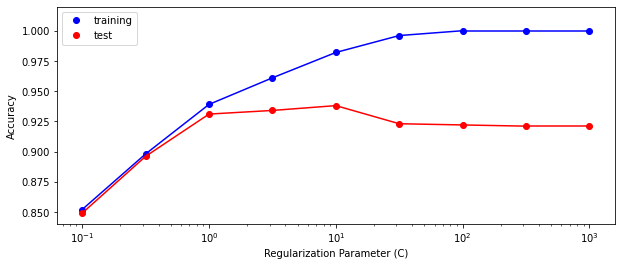

In [ ]:
# test different models based on different regularization parameters, illustrate results
C_values = [10**-1, 10**-0.5, 10**0, 10**0.5, 10**1, 10**1.5, 10**2, 10**2.5, 10**3]
result_ratios_train = []
result_ratios_test = []

for i in range(len(C_values)):
  result = get_alpha_and_w0(C_values[i])
  alpha = result[0]
  w0 = result[1]

  f_predicted_train = np.matmul(K_train, train_set_y[:,None] * alpha[:,None]) + w0
  f_predicted_test = np.matmul(K_test, train_set_y[:,None] * alpha[:,None]) + w0

  y_predicted_train = 2 * (f_predicted_train > 0.0) - 1
  y_predicted_test = 2 * (f_predicted_test > 0.0) - 1

  count_equal_train = np.sum(np.reshape(y_predicted_train, N_train) == train_set_y)
  count_equal_test = np.sum(np.reshape(y_predicted_test, N_test) == test_set_y)

  ratio_train = count_equal_train / len(y_predicted_train)
  ratio_test = count_equal_test / len(y_predicted_test)

  result_ratios_train.append(ratio_train)
  result_ratios_test.append(ratio_test)

print()
print()
print()

# plot results
plt.figure(figsize = (10, 4))
plt.plot(C_values, result_ratios_train, "b.", markersize = 12, label = 'training')
plt.plot(C_values, result_ratios_test, "r.", markersize = 12, label = 'test')
plt.ylabel('Accuracy')
plt.xlabel('Regularization Parameter (C)')
plt.semilogx(10)
plt.ylim(0.84, 1.02)
plt.legend()
for b in range(len(result_ratios_train) - 1):
  plt.plot([C_values[b], C_values[b + 1]], [result_ratios_train[b], result_ratios_train[b + 1]], color = 'blue')
for b in range(len(result_ratios_test) - 1):
  plt.plot([C_values[b], C_values[b + 1]], [result_ratios_test[b], result_ratios_test[b + 1]], color = 'red')